# Stacked LSTMs with Memory Between Batches

LSTM adalah salah satu jenis dari jaringan saraf rekuren (Recurrent Neural Network atau RNN) yang dirancang untuk mengatasi masalah "vanishing gradient" yang sering terjadi dalam jaringan saraf rekuren konvensional.

berbeda dengan neural network yang menggunakan neuron seperti umumnya, LSTM menggunakan memory block pada masing-masing layer

Berikut merupakan struktur dari LSTM:

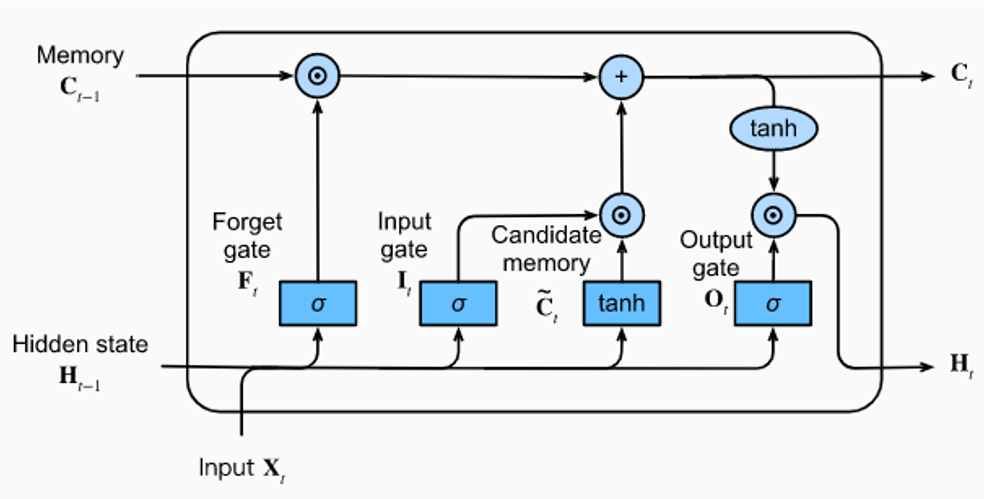

1. Input Gate:

Input gate mengontrol seberapa banyak informasi baru akan diintegrasikan ke dalam cell state.
Ini melibatkan fungsi aktivasi sigmoid yang mengambil input dari input data dan hidden state pada langkah sebelumnya.
Hasil sigmoid mengindikasikan sejauh mana setiap elemen informasi baru akan dimasukkan ke dalam cell state.

2. Forget Gate:

Forget gate menentukan sejauh mana informasi dari cell state sebelumnya akan dijaga atau dilupakan.
Ini juga menggunakan fungsi aktivasi sigmoid yang mengambil input dari input data dan hidden state sebelumnya.
Hasil sigmoid mengindikasikan sejauh mana elemen-elemen cell state sebelumnya akan dihilangkan atau dipertahankan.

3. Cell State:

Cell state adalah komponen internal LSTM yang menyimpan informasi dalam jangka waktu yang panjang.
Informasi baru ditambahkan ke cell state melalui input gate dan informasi lama dihapus atau dipertahankan melalui forget gate.
Ini adalah komponen utama yang memungkinkan LSTM untuk mengingat informasi jangka panjang.

4. Output Gate:

Output gate mengatur sejauh mana cell state saat ini akan memengaruhi hidden state dan output model.
Ini melibatkan fungsi aktivasi sigmoid yang mengambil input dari input data dan hidden state sebelumnya serta cell state saat ini.
Hasil sigmoid mengontrol berapa banyak informasi dalam cell state yang akan disalurkan ke hidden state dan output model.

5. Hidden State:

Hidden state adalah keluaran aktual dari LSTM pada suatu langkah waktu tertentu.
Ini mencerminkan informasi yang telah diproses oleh LSTM pada langkah waktu sebelumnya dan informasi dari cell state saat ini.
Hidden state juga dapat digunakan sebagai input untuk langkah waktu berikutnya.

## Code below!1

### Modules

In [22]:
#Stacked LSTMs with Memory Between Batches

#modules
import tensorflow as tf
from tensorflow import keras
from keras import layers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm

from sklearn.preprocessing import MinMaxScaler

import haha
from sklearn.metrics import mean_squared_error


#random seed sehingga seed modelling pada module tensorflow dapat direplikasi
tf.random.set_seed(7)

### Ambil data dan normalisasi

Kenapa normalisasi?

karena model LSTM sensitif dengan skala data input yang dapat mengacaukan akurasi sebuah model. Terutama jika aktivisasi sigmoid atau tanh digunakan pada layer (keduanya menghasilkan hasil 0 sampai 1)

In [38]:
#load dataset
df=pd.read_csv("../../Data/Harian/Rata Harian.csv").iloc[:,2]

#get data from 15 latest months
df=df[-(30*15):]

In [39]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df.values.reshape(-1,1))

In [5]:
#train test split; train 12 months, 3 months for testing
train=df[:30*12]; test=df[30*12:]

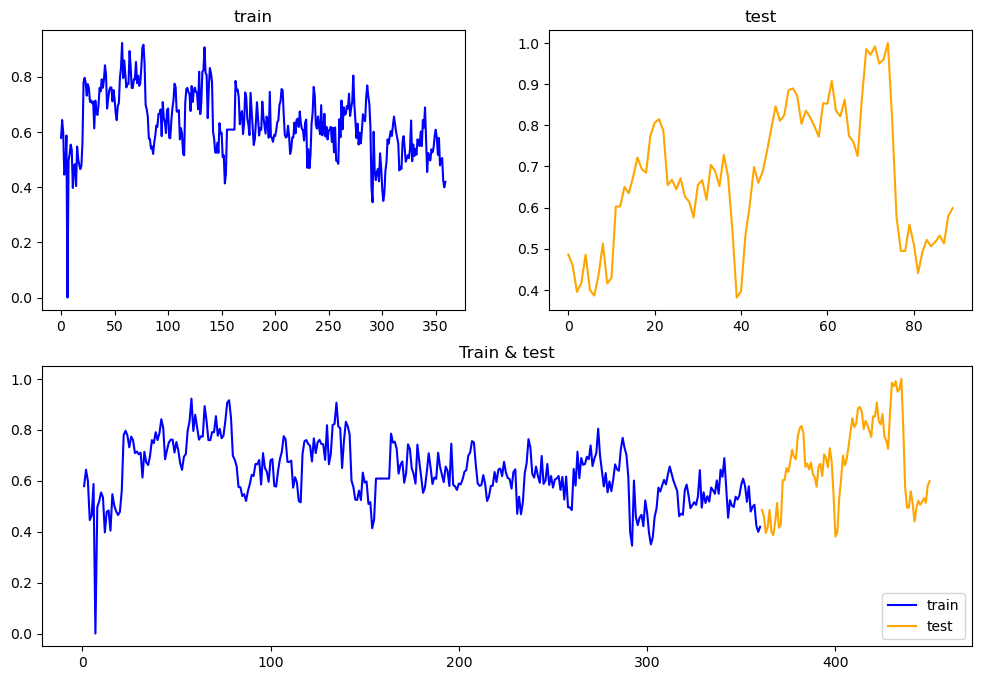

In [6]:
haha.plottraintest(train, test)

### Metode Window

Data diubah dengan lag 30       (Bebas mau pake lag berapa sebenernya)

In [26]:
# reshape into X=t and Y=t+1

t=30
trainX, trainY = haha.lag(train,t)
testX, testY = haha.lag(test,t)

In [27]:
#ubah data sehingga kompatibel dengan shape input model
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Model

Menggunakan stacked LSTM (layer pada model lebih dari 1) untuk Meningkatkan Kinerja Prediksi


You can gain finer control over when the internal state of the LSTM network is cleared in Keras by making the LSTM layer “stateful.” This means it can build a state over the entire training sequence and even maintain that state if needed to make predictions.

It requires that the training data not be shuffled when fitting the network. It also requires explicit resetting of the network state after each exposure to the training data (epoch) by calls to model.reset_states(). This means that you must create your own outer loop of epochs and within each epoch call model.fit() and model.reset_states().

In [28]:
batch_size=1

#create model
def getmodel_compile():
    model=keras.Sequential([
        keras.layers.LSTM(4, batch_input_shape=(batch_size, t, 1), stateful=True, return_sequences=True),                   #input and 1st memory block
        keras.layers.LSTM(8, batch_input_shape=(batch_size, t, 1), stateful=True),                                          #2nd memory block
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=keras.metrics.RootMeanSquaredError())
    return model

In [29]:
model=getmodel_compile()

for i in range(100):
    model.fit(trainX, trainY, epochs=1, validation_data=(testX, testY), batch_size=batch_size, verbose=1)
    model.reset_states()

329/329 [==============================] - 4s 13ms/step - loss: 0.0041 - root_mean_squared_error: 0.0644 - val_loss: 0.0061 - val_root_mean_squared_error: 0.0782


In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (1, 30, 4)                96        
                                                                 
 lstm_5 (LSTM)               (1, 8)                    416       
                                                                 
 dense_2 (Dense)             (1, 1)                    9         
                                                                 
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [31]:
#Lets predict and check performance metrics
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

59/59 [==============================] - 0s 6ms/step


In [32]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

df=scaler.inverse_transform(df)
testY = scaler.inverse_transform([testY])
trainY = scaler.inverse_transform([trainY])

In [33]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4.89 RMSE
Test Score: 6.20 RMSE


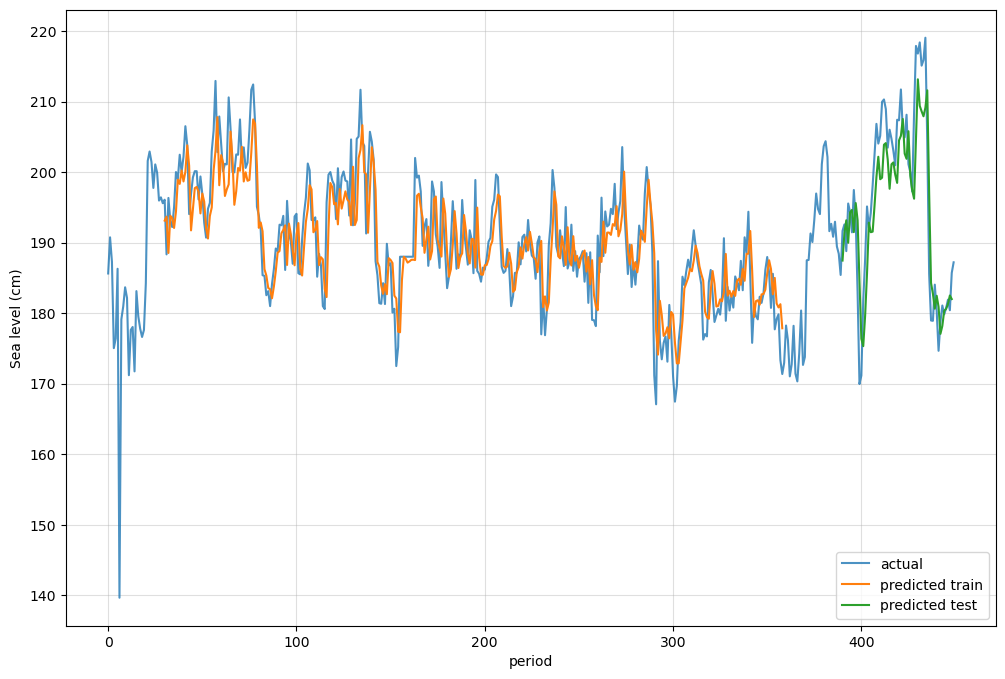

In [42]:
haha.plot_predicted(df, trainPredict, testPredict, t)

Predict the next 30 days

#Not finished

In [194]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [195]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

ValueError: cannot reshape array of size 88 into shape (1,100,1)

In [115]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [116]:
df3 = df_close.tolist()
df3.extend(lst_output)

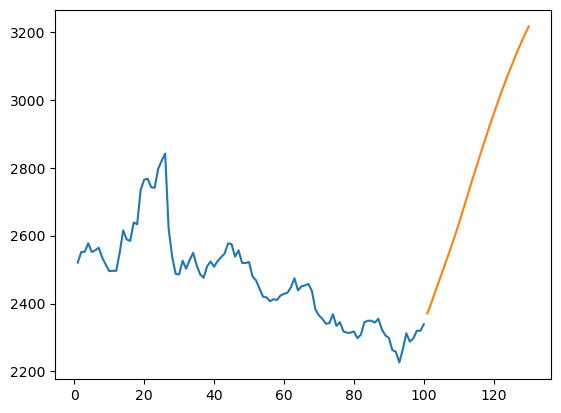

In [118]:
plt.plot(day_new, scaler.inverse_transform(df_close[-100:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

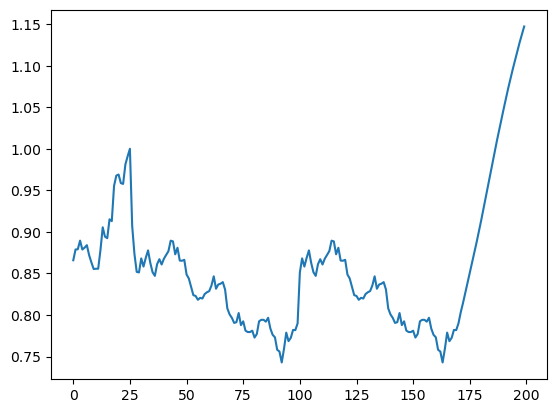

In [124]:
plt.plot(np.append(temp, x_input))